In [ ]:
!pip install -q -U tensorflow-text
!pip install torchvision 
!pip install -q tf-models-official
!pip install transformers
!pip install emoji

     |████████████████████████████████| 4.6 MB 10.0 MB/s 
     |████████████████████████████████| 511.7 MB 4.3 kB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 438 kB 50.5 MB/s 
     |████████████████████████████████| 5.8 MB 40.8 MB/s 
     |████████████████████████████████| 2.1 MB 12.4 MB/s 
     |████████████████████████████████| 237 kB 50.1 MB/s 
     |████████████████████████████████| 636 kB 50.2 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 47.8 MB 59.3 MB/s 
     |████████████████████████████████| 352 kB 54.0 MB/s 
     |████████████████████████████████| 1.1 MB 27.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.8 MB/s 
     |████████████████████████████████| 92 kB 10.9 MB/s 
     |████████████████████████████████| 4.2 MB 11.8 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |█████████████

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification,BertForSequenceClassification, BertTokenizer,  AdamW
from seqeval.metrics import classification_report
import pickle

import nltk
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
import emoji
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub("", text)

In [ ]:
path = '/content/drive/Shareddrives/CrimeTrack: Tracking Crime on the Web/Data/Train Dataset/training_dataset_labels.xlsx'

In [ ]:
file = pd.read_excel(path)

In [ ]:
file.head()

,username,creation_date,tweet,label,category,crime_type
0,guardiacivil,2017-10-13 20:00:02+00:00,"Es indiferente el evento, la fiesta, el lugar,...",Not Crime,0.0,NaN
1,guardiacivil,2022-01-07 14:00:00+00:00,El #ServicioAéreo y el #ServiciodeMontaña de l...,Not Crime,0.0,NaN
2,guardiacivil,2018-01-23 12:00:02+00:00,"""Paco"" arañó un vehículo cuando estaba aparcan...",Not Crime,0.0,NaN
3,guardiacivil,2021-06-03 14:00:00+00:00,Los requisitos específicos para participar en ...,Not Crime,0.0,NaN
4,guardiacivil,2018-01-16 08:00:01+00:00,"Esta semana el ""grajo va a volar muy bajo"", e ...",Not Crime,0.0,NaN


In [ ]:
file = file.loc[file['label'] == 'Crime']

In [ ]:
file = file.reset_index(drop=True)

In [ ]:
file['tweet_processed'] = ''
for i in range(len(file)):
  file['tweet_processed'][i] = give_emoji_free_text(file.tweet[i])

In [ ]:
len(file)

886

In [ ]:
file.crime_type.unique()

array(['Drug Trafficking', 'Escape', 'Phishing', 'Robbery',
       'Arms Possession And Trafficking', 'Human Trafficking',
       'Crime Against Animals', 'Homicide', 'Public Disorder',
       'Terrorism', 'Sexual Violence', 'False Report',
       'Falsification and Illegal Sale', 'Fraud', 'Abduction', 'Theft',
       'Injury'], dtype=object)

In [ ]:
file.loc[file['crime_type'].isnull()]

,username,creation_date,tweet,label,category,crime_type,tweet_processed


In [ ]:
file.crime_type.unique()

array(['Drug Trafficking', 'Escape', 'Phishing', 'Robbery',
       'Arms Possession And Trafficking', 'Human Trafficking',
       'Crime Against Animals', 'Homicide', 'Public Disorder',
       'Terrorism', 'Sexual Violence', 'False Report',
       'Falsification and Illegal Sale', 'Fraud', 'Abduction', 'Theft',
       'Injury'], dtype=object)

In [ ]:
from collections import Counter
Counter(file.crime_type)

Counter({'Abduction': 40,
         'Arms Possession And Trafficking': 35,
         'Crime Against Animals': 33,
         'Drug Trafficking': 174,
         'Escape': 36,
         'False Report': 18,
         'Falsification and Illegal Sale': 52,
         'Fraud': 70,
         'Homicide': 54,
         'Human Trafficking': 35,
         'Injury': 49,
         'Phishing': 58,
         'Public Disorder': 39,
         'Robbery': 34,
         'Sexual Violence': 72,
         'Terrorism': 32,
         'Theft': 55})

In [ ]:
all_tags = sorted(set(file.crime_type.unique()))
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

Number of tags: 17
Tags: ['Abduction', 'Arms Possession And Trafficking', 'Crime Against Animals', 'Drug Trafficking', 'Escape', 'False Report', 'Falsification and Illegal Sale', 'Fraud', 'Homicide', 'Human Trafficking', 'Injury', 'Phishing', 'Public Disorder', 'Robbery', 'Sexual Violence', 'Terrorism', 'Theft']


In [ ]:
tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

In [ ]:
file['crime_label'] = 0
for i in range(len(file)): 
   file['crime_label'][i] = tag2index[file['crime_type'][i]]

In [ ]:
file = file.sample(frac=1).reset_index(drop=True)

In [ ]:
X = [tweet for tweet in file.tweet_processed]
y = [ label for label in file.crime_label]

# splitting data from training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print("X[0]:", X[0])
print("y[0]:", y[0])

print("Size X_train: ", len(X_train))
print("Size X_valid: ", len(X_valid))
print("Size X_test: ", len(X_test))

X[0]: Te dicen que han activado tu cámara web y te han grabado...
Se trata de un mensaje masivo intentando estafarte

#NoPiques
#Sextorsión
y[0]: 11
Size X_train:  708
Size X_valid:  89
Size X_test:  89


In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 34,
         1: 29,
         2: 26,
         3: 139,
         4: 32,
         5: 12,
         6: 41,
         7: 52,
         8: 45,
         9: 24,
         10: 38,
         11: 46,
         12: 34,
         13: 28,
         14: 59,
         15: 24,
         16: 45})

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
max_length = 512

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [ ]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.X[index]
        label = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(text,
                             padding='max_length', max_length = self.max_len, 
                              truncation=True, return_tensors="pt")
        
        encoding['label'] = torch.tensor(label)
        return encoding

In [ ]:
max_seq_len = 128
training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

In [ ]:
training_set[0]

{'input_ids': tensor([[    4,  1030,  2962,  2596, 26903,  1040, 14904, 19757,  1008,  1049,
         13651,  4436,  1036,  2311,  3722,  1017,  1091,  1038,  6560,  2404,
          1042,  7316,  1948,  1668,  1108,  6668,  1008,  2544,     5,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [ ]:
max_seq_len = max([len(x) for x in X])
print("max_seq_leng:", max_seq_len)

max_seq_leng: 304


In [ ]:
training_set[0]["label"]

tensor(0)

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(tag2index))
model = model.to(device)

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [ ]:
TRAIN_BATCH_SIZE = 40
VALID_BATCH_SIZE = 40
EPOCHS = 10
LEARNING_RATE = 1e-05

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
inputs = { key: training_set[1][key] for key in ['input_ids','token_type_ids','attention_mask','label'] }
ids = inputs['input_ids'].to(device)
mask = inputs['attention_mask'].to(device)

labels =inputs['label'].to(device)
outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(3.0635, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits

tensor([[ 0.1962,  0.2568,  0.0970, -0.2086, -0.0262, -0.1237,  0.0734,  0.2566,
         -0.1894, -0.0595, -0.0029, -0.2511, -0.2099,  0.1838, -0.0154,  0.0295,
          0.1204]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8 )

In [ ]:
from pandas._libs.index import BaseMultiIndexCodesEngine
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            if batch['input_ids'].squeeze().shape[0] == 128:
              ids = batch['input_ids'].squeeze(0).to(device)
              mask = batch['attention_mask'].squeeze(0).to(device)
              labels = batch['label'].to(device)

            else: 
              ids = batch['input_ids'].squeeze().to(device)
              mask = batch['attention_mask'].squeeze().to(device)
              labels = batch['label'].to(device)

            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')
            
            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  

            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
            
            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")
            
            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
          
    
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
            
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy
        
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)
    
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
              
    _, _ , val_loss, val_acc = valid(model, validation_loader)
    
    return epoch_loss, tr_accuracy, val_loss, val_acc

In [ ]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)

Epoch 9: 100%|██████████| 18/18 [00:28<00:00,  1.58s/it, accuracy=1, loss=0.0838]


<function matplotlib.pyplot.show>

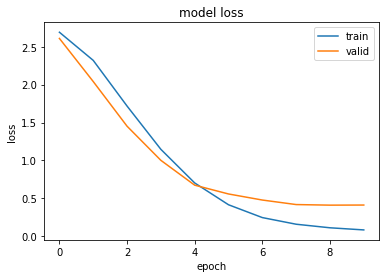

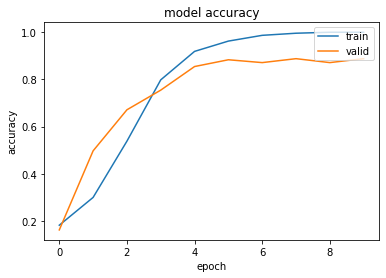

In [ ]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [ ]:
from sklearn.metrics import classification_report

labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")
print(classification_report(labels, predictions))

Validation : loss 0.38 accuracy 0.90
                                 precision    recall  f1-score   support

                      Abduction       1.00      0.67      0.80         3
Arms Possession And Trafficking       1.00      1.00      1.00         2
          Crime Against Animals       1.00      1.00      1.00         4
               Drug Trafficking       1.00      1.00      1.00        19
                         Escape       1.00      1.00      1.00         2
                   False Report       0.67      0.50      0.57         4
 Falsification and Illegal Sale       1.00      1.00      1.00         3
                          Fraud       0.90      0.69      0.78        13
                       Homicide       1.00      0.80      0.89         5
              Human Trafficking       1.00      1.00      1.00         2
                         Injury       0.80      1.00      0.89         4
                       Phishing       0.83      1.00      0.91         5
             

In [ ]:
not_classified = []
for i in range(len(labels)): 
  if labels[i] != predictions[i]:
    not_classified.append(i)
  

In [ ]:
len(not_classified)

8

In [ ]:
def inference(sentence, tokenizer):
    inputs = tokenizer(sentence,padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    
    token_predictions = [index2tag[i] for i in flattened_predictions.cpu().numpy()]

    return token_predictions

In [ ]:
for i in range(len(not_classified)):
  sentence = X_test[not_classified[i]]
  print('Tweet:', sentence)
  print('Label:', index2tag[y_test[not_classified[i]]])
  entities = inference(sentence,tokenizer)
  print('Prediction:',entities)
  print('################')

Tweet:  La Policía Nacional ha detenido a los autores de un apuñalamiento en las Tres Mil Viviendas  Sevilla

 Los agresores pertenecen a un clan familiar
 Entre otros delitos, están acusados de tentativa de homicidio, amenazas graves o tenencia ilícita de armas.

 @policia https://t.co/ABci4TixhJ
Label: Homicide
Prediction: ['Injury']
################
Tweet: No dejes q tus mayores piquen! RT @romangp: Timan 7.400 euros a dos ancianas con el "tocomocho" #Gijon @policia http://t.co/8Lzc8a6WQD
Label: Fraud
Prediction: ['Phishing']
################
Tweet: La Policía Nacional ha detenido al conocido como Lupín, uno de los ciberestafadores más buscados de España, en una discoteca de Madrid. 

https://t.co/Y3EPYhJOOT
Label: Fraud
Prediction: ['Terrorism']
################
Tweet: Liberado menor encerrado por su madre en una habitación en condiciones infrahumanas #Almería https://t.co/kQT3ZO4s8z https://t.co/KF05sCyECd
Label: Abduction
Prediction: ['Sexual Violence']
################
Tweet: 5 

# Nueva sección

In [ ]:
directory = Path("/content/drive/Shareddrives/CrimeTrack: Tracking Crime on the Web/Model/Model Crime Type_90_TOP")
directory.mkdir(parents=True, exist_ok=True)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(str(directory))
# save the model weights and its configuration file
model.save_pretrained(directory)

parameters = (max_seq_len, all_tags, tag2index, index2tag)
pickle.dump(parameters, (directory / 'parrameters.pk').open('wb'))

print('All files saved')

All files saved
